We need python 3.10 <br>
tensorflow 2.15.1 or anything lower than 2.16 <br> lastly voxelmorph 0.2

First asseble all the patients data into one numpy array having the shape of (number of patients, 2- which are endsystoel & dyastole, number of slices, 2-image & mask, 128*128 )

In [1]:
import os
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import voxelmorph as vxm
import neurite as ne

In [3]:
base_path = os.getcwd()
data_path = os.path.join(base_path, "../../Data/combined_data.npy")
if os.path.exists(data_path):
  organized_data = np.load(data_path)
  print("Loaded organized data from saved file.")
  print("Data has size {} in gigabytes.".format(organized_data.nbytes / 1e9))
else:
  print("No organized data found. Please run organize_data.ipynb first.")

Loaded organized data from saved file.
Data has size 1.36839168 in gigabytes.


In [4]:
print("Data shape: ", organized_data.shape)

Data shape:  (145, 18, 2, 2, 128, 128)


In [5]:
def plot_numpy_array(numpy_array):
    """
    Plot a 2-channel NumPy array.
    """
    
    # Extract the image and the mask
    image = numpy_array[0]
    mask = numpy_array[1]

    # Plot the image, the mask, and the overlay
    plt.figure(figsize=(12, 4))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='viridis')  # Use a different colormap for the mask
    plt.axis('off')

    # Plot the overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap='gray')  # Base image
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

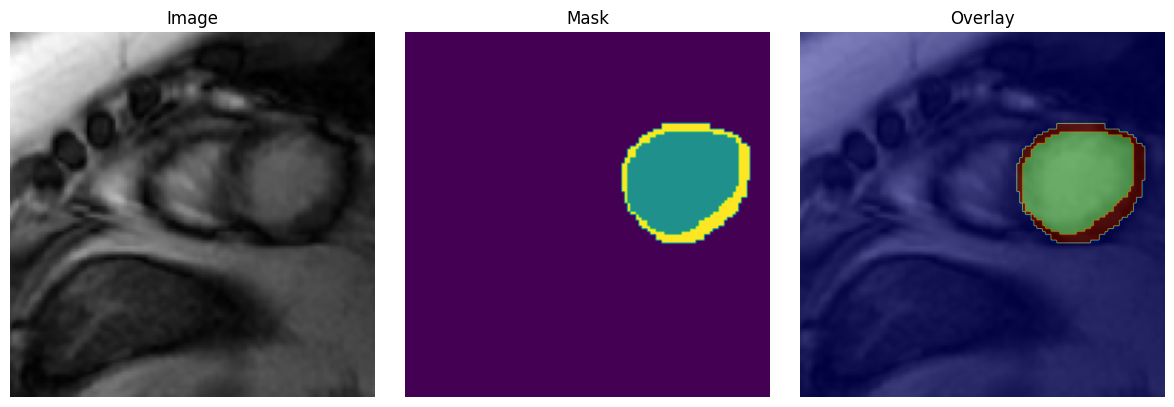

In [6]:
# Plot a sample image
patient_idx = 144
stage_idx = 0
slice_idx = 5
plot_numpy_array(organized_data[patient_idx, slice_idx, stage_idx])

In [7]:
from sklearn.model_selection import train_test_split

# Split patients into training and validation sets
num_patients = organized_data.shape[0]
train_idx, val_idx = train_test_split(range(num_patients), test_size=0.2, random_state=42)

# Create training and validation datasets
train_data = organized_data[train_idx]
val_data = organized_data[val_idx]

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (116, 18, 2, 2, 128, 128)
Validation data shape: (29, 18, 2, 2, 128, 128)


In [8]:
# Check a few slices in train_data
print(f"train_data[0, 0, 0]:\n{train_data[0, 0, 0]}")
print(f"Non-zero values in train_data[0, 0, 0]: {np.count_nonzero(train_data[0, 0, 0])}")

# Check a few slices in val_data
print(f"val_data[0, 0, 0]:\n{val_data[0, 0, 0]}")
print(f"Non-zero values in val_data[0, 0, 0]: {np.count_nonzero(val_data[0, 0, 0])}")

train_data[0, 0, 0]:
[[[-0.66605643 -0.64140219 -0.65984245 ... -0.71119967 -0.71671497
   -0.71807152]
  [-0.50481547 -0.59350741 -0.65332736 ... -0.69194514 -0.70294546
   -0.70986065]
  [-0.33710953 -0.57334304 -0.60459878 ... -0.68313652 -0.6820576
   -0.68682957]
  ...
  [-0.22822168 -0.2226955  -0.23016949 ... -0.65430364 -0.66838318
   -0.67657263]
  [-0.22340567 -0.23494071 -0.25359869 ... -0.63563391 -0.61123247
   -0.60932921]
  [-0.26784939 -0.26812016 -0.2784265  ... -0.66711678 -0.5982019
   -0.57289306]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]
Non-zero values i

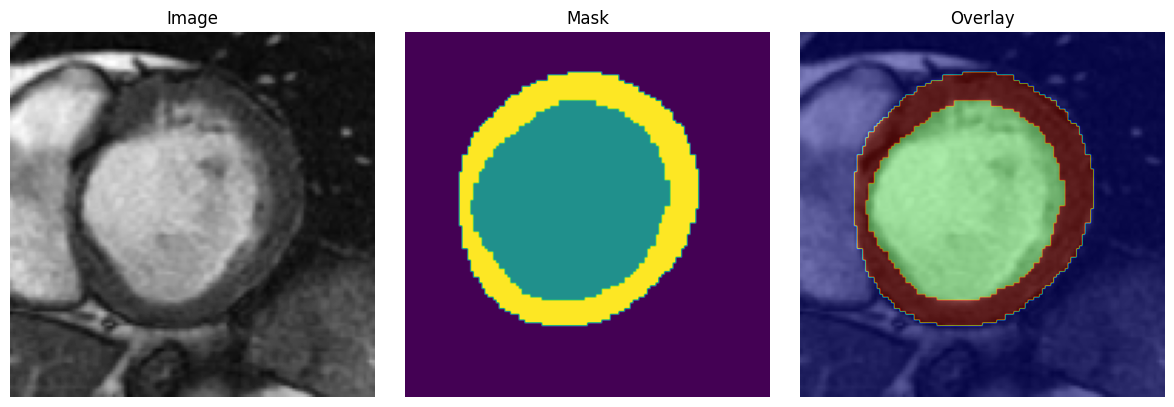

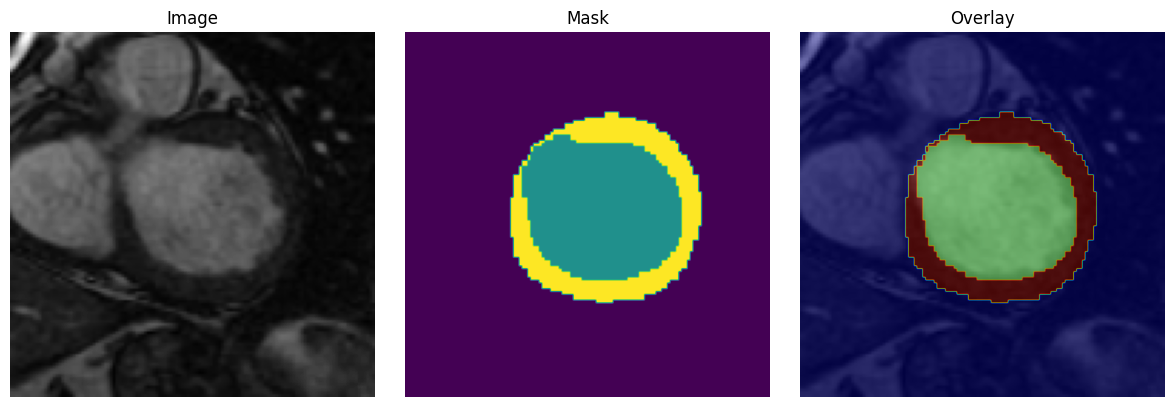

In [9]:
# Plot a sample image from the training set and the validation set
patient_idx = 115
stage_idx = 0
slice_idx = 0
plot_numpy_array(train_data[patient_idx, slice_idx, stage_idx])

patient_idx = 28
stage_idx = 0
slice_idx = 0
plot_numpy_array(val_data[patient_idx, slice_idx, stage_idx])

In [12]:
def prepare_pairs(data, padding_value=0):
    """
    Prepares fixed and moving image pairs for training/validation, excluding padded slices.

    Parameters:
        data (np.ndarray): Data of shape (num_patients, max_slices, num_stages, 2, 128, 128).
        padding_value (int or float): The value used to pad the slices (default is 0).

    Returns:
        tuple: Fixed images, Moving images, Masks for fixed and moving.
    """
    fixed_images = []
    moving_images = []
    fixed_masks = []
    moving_masks = []

    # Loop over all patients
    for patient_data in data:
        # Loop over all slices in the patient data
        for slice_data in patient_data:
            # Loop over all stages in the slice data
            for stage_idx in range(len(slice_data) - 1):  # We need pairs, so we go to len-1
                # Get the fixed image (current stage) and moving image (next stage)
                fixed_image, moving_image = slice_data[stage_idx, 0], slice_data[stage_idx + 1, 0]
                fixed_mask, moving_mask = slice_data[stage_idx, 1], slice_data[stage_idx + 1, 1]

                # Check if the fixed and moving images are not padded (i.e., not equal to padding_value)
                if not np.all(fixed_image == padding_value) and not np.all(moving_image == padding_value):
                    # Check if the fixed and moving masks are also not padded
                    if not np.all(fixed_mask == padding_value) and not np.all(moving_mask == padding_value):
                        # Append the valid fixed and moving images and their corresponding masks
                        fixed_images.append(fixed_image)
                        moving_images.append(moving_image)
                        fixed_masks.append(fixed_mask)
                        moving_masks.append(moving_mask)

    # Convert the lists to numpy arrays
    fixed_images = np.array(fixed_images)  # Shape: (num_pairs, 128, 128)
    moving_images = np.array(moving_images)  # Shape: (num_pairs, 128, 128)
    fixed_masks = np.array(fixed_masks)  # Shape: (num_pairs, 128, 128)
    moving_masks = np.array(moving_masks)  # Shape: (num_pairs, 128, 128)

    return fixed_images, moving_images, fixed_masks, moving_masks


In [13]:
# Prepare training and validation pairs
train_fixed, train_moving, train_fixed_mask, train_moving_mask = prepare_pairs(train_data)
val_fixed, val_moving, val_fixed_mask, val_moving_mask = prepare_pairs(val_data)

In [16]:
print("Training data:")
print("Fixed images shape:", train_fixed.shape)
print("Moving images shape:", train_moving.shape)
print("Fixed masks shape:", train_fixed_mask.shape)
print("Moving masks shape:", train_moving_mask.shape)

print("\nValidation data:")
print("Fixed images shape:", val_fixed.shape)
print("Moving images shape:", val_moving.shape)
print("Fixed masks shape:", val_fixed_mask.shape)
print("Moving masks shape:", val_moving_mask.shape)

Training data:
Fixed images shape: (990, 128, 128)
Moving images shape: (990, 128, 128)
Fixed masks shape: (990, 128, 128)
Moving masks shape: (990, 128, 128)

Validation data:
Fixed images shape: (250, 128, 128)
Moving images shape: (250, 128, 128)
Fixed masks shape: (250, 128, 128)
Moving masks shape: (250, 128, 128)


In [17]:
# Loop over all slices in the training set to make sure that the number of non-zero values in the fixed and moving images is greater than zero.
counter = 0
indices = []
for i in range(len(train_fixed)):
    if np.count_nonzero(train_fixed[i]) == 0 or np.count_nonzero(train_moving[i]) == 0:
        counter += 1
        indices.append(i)
print(f"Number of slices with all-zero fixed or moving images: {counter}")
print(f"Indices of slices with all-zero fixed or moving images: {indices}")

Number of slices with all-zero fixed or moving images: 0
Indices of slices with all-zero fixed or moving images: []


In [18]:
sample_idx = 254

print(f"Sample index: {sample_idx}")
print(f"Max training index: {len(train_fixed) - 1}")
print(f"Max validation index: {len(val_fixed) - 1}")

Sample index: 254
Max training index: 989
Max validation index: 249


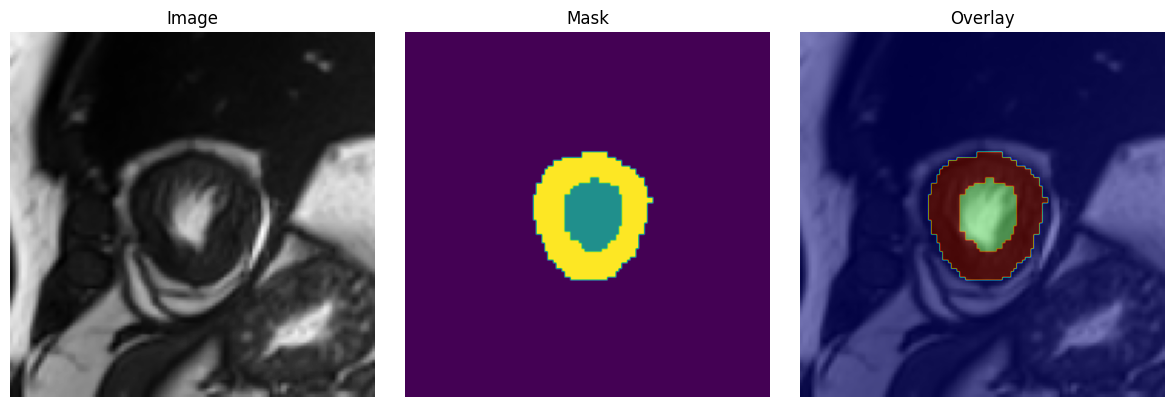

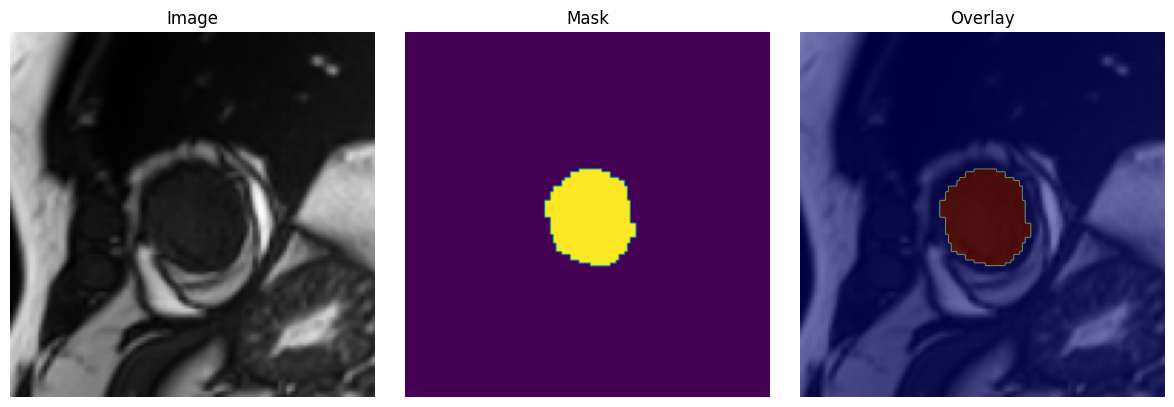

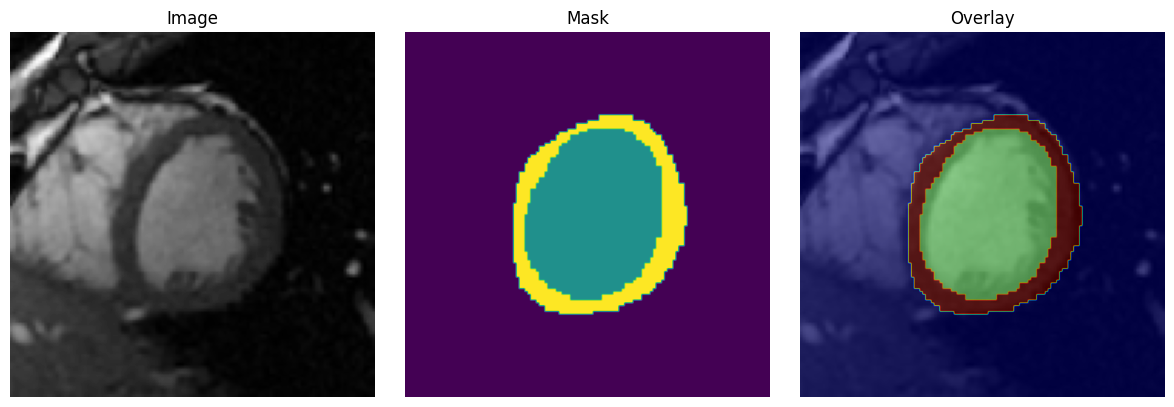

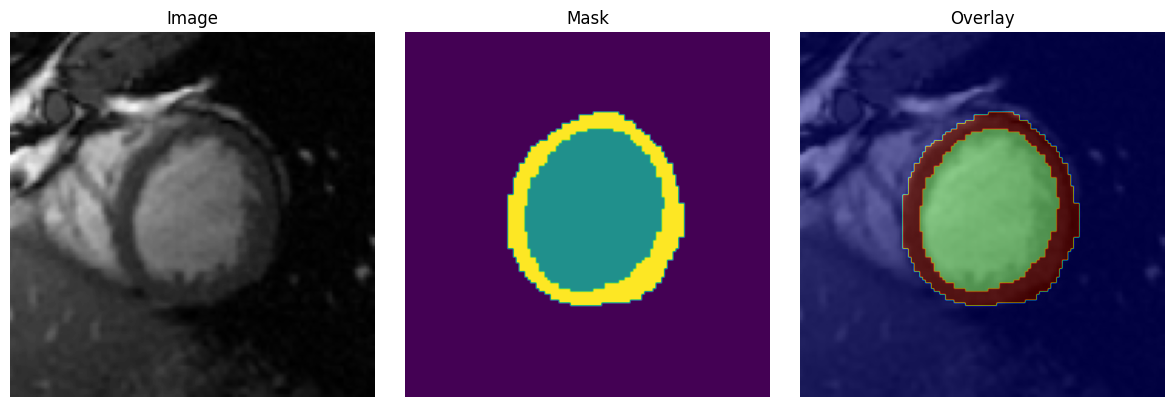

In [20]:
# Plot a sample pair of fixed and moving images with masks (training data, validataion data)
plot_numpy_array(np.array([train_fixed[sample_idx], train_fixed_mask[sample_idx]]))
plot_numpy_array(np.array([train_moving[sample_idx], train_moving_mask[sample_idx]]))

sample_idx = 10
plot_numpy_array(np.array([val_fixed[sample_idx], val_fixed_mask[sample_idx]]))
plot_numpy_array(np.array([val_moving[sample_idx], val_moving_mask[sample_idx]]))


In [28]:
# Define the input shape for fixed and moving images
input_shape = (128, 128)  # Single channel for 2D images

# Define U-Net features
nb_features = [
    [64, 128, 256, 512],         # encoder features
    [256, 128, 64, 32, 32]  # decoder features
]

# Create the VoxelMorph model
vm_model = vxm.networks.VxmDense(
    inshape=input_shape,
    nb_unet_features=nb_features,
    int_steps= 0 # Integration steps
)

# Losses
losses = [
    vxm.losses.NCC().loss,          # Intensity similarity loss
    vxm.losses.Grad('l2').loss     # Smoothness of the deformation field
]
loss_weights = [1, 0.09]

# Compile the model
vm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 loss=losses,
                 loss_weights=loss_weights)

In [29]:
def vxm_data_generator_2d(moving_images, fixed_images, batch_size):
    """
    Data generator for 2D image registration using VoxelMorph.
    
    Parameters:
        x_data (np.ndarray): Moving images dataset of shape [N, H, W].
        y_data (np.ndarray): Fixed images dataset of shape [N, H, W].
        batch_size (int): Number of samples per batch.

    Yields:
        Tuple: ([moving_images, fixed_images], [fixed_images, zero_phi])
               - moving_images: Batch of moving images [batch_size, H, W, 1].
               - fixed_images: Batch of fixed images [batch_size, H, W, 1].
               - zero_phi: Zero deformation field for smoothness loss.
    """
    # Preliminary sizing
    vol_shape = moving_images.shape[1:]  # Extract data shape (H, W)
    ndims = len(vol_shape)  # Number of spatial dimensions (2 for 2D)

    # Prepare a zero deformation field for smoothness loss
    zero_phi = np.zeros([batch_size, *vol_shape, ndims], dtype=np.float32)

    while True:
        # Randomly sample moving and fixed images
        idx = np.random.randint(0, moving_images.shape[0], size=batch_size)
        moving_images_batch = moving_images[idx, ..., np.newaxis]  # Add channel dimension
        
        fixed_images_batch = fixed_images[idx, ..., np.newaxis]  # Add channel dimension

        # Inputs: moving and fixed images
        inputs = [moving_images_batch, fixed_images_batch]

        # Outputs: fixed images and zero deformation field
        outputs = [fixed_images_batch, zero_phi]

        yield (inputs, outputs)




In [30]:
# Create training generator
train_generator = vxm_data_generator_2d(train_moving, train_fixed, batch_size=16)
# Create validation generator
val_generator = vxm_data_generator_2d(val_moving, val_fixed, batch_size=16)

sample_inputs, sample_outputs = next(train_generator)
print("Inputs:", [s.shape for s in sample_inputs])
print("Outputs:", [s.shape for s in sample_outputs])

Inputs: [(16, 128, 128, 1), (16, 128, 128, 1)]
Outputs: [(16, 128, 128, 1), (16, 128, 128, 2)]


In [32]:
# Define training parameters
nb_epochs = 150
steps_per_epoch = 100
validation_steps = 20

# Train the model
history = vm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)


Epoch 1/150
100/100 - 97s - loss: -2.4629e-01 - vxm_dense_transformer_loss: -2.4657e-01 - vxm_dense_flow_loss: 0.0032 - val_loss: -2.7950e-01 - val_vxm_dense_transformer_loss: -2.8086e-01 - val_vxm_dense_flow_loss: 0.0151 - 97s/epoch - 970ms/step
Epoch 2/150
100/100 - 95s - loss: -3.1735e-01 - vxm_dense_transformer_loss: -3.1872e-01 - vxm_dense_flow_loss: 0.0153 - val_loss: -3.1753e-01 - val_vxm_dense_transformer_loss: -3.1947e-01 - val_vxm_dense_flow_loss: 0.0216 - 95s/epoch - 952ms/step
Epoch 3/150
100/100 - 98s - loss: -3.4922e-01 - vxm_dense_transformer_loss: -3.5145e-01 - vxm_dense_flow_loss: 0.0249 - val_loss: -3.4345e-01 - val_vxm_dense_transformer_loss: -3.4617e-01 - val_vxm_dense_flow_loss: 0.0302 - 98s/epoch - 983ms/step
Epoch 4/150
100/100 - 97s - loss: -3.6144e-01 - vxm_dense_transformer_loss: -3.6479e-01 - vxm_dense_flow_loss: 0.0372 - val_loss: -3.5564e-01 - val_vxm_dense_transformer_loss: -3.5991e-01 - val_vxm_dense_flow_loss: 0.0474 - 97s/epoch - 970ms/step
Epoch 5/150


In [33]:
# Save the model
vm_model.save('voxel_morph_model.keras')

# Load and apply the model
loaded_model = tf.keras.models.load_model('voxel_morph_model.keras', compile=False)



In [39]:
# Prepare the input data for prediction
sample_idx = 15
fixed_image = val_fixed[sample_idx][np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
moving_image = val_moving[sample_idx][np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Predict the warped image and deformation field
predicted_warp, deformation_field = loaded_model.predict([moving_image, fixed_image])

1/1 [==============================] - 0s 350ms/step


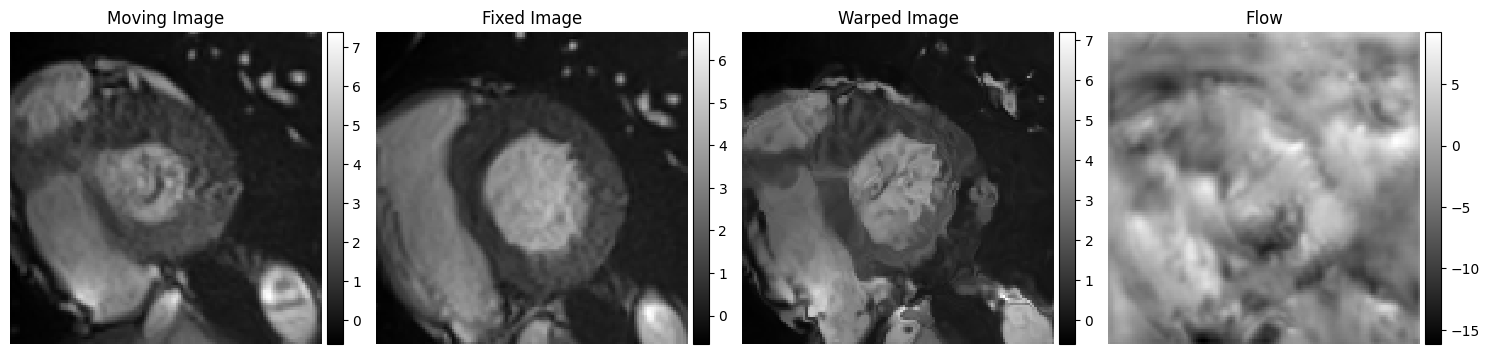

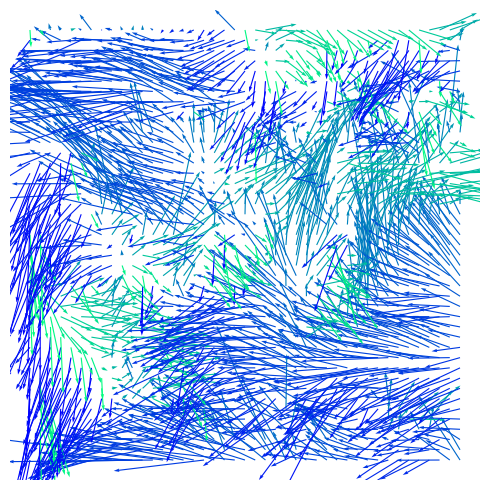

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [40]:
# Prepare the inputs and outputs for visualization
val_input = [moving_image, fixed_image]
val_pred = [predicted_warp, deformation_field]

# Extract the images for visualization
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['Moving Image', 'Fixed Image', 'Warped Image', 'Flow']

# Visualize the slices
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

# Visualize the flow field
flow = deformation_field.squeeze()[::3, ::3]  # Downsample for better visualization
ne.plot.flow([flow], width=5)

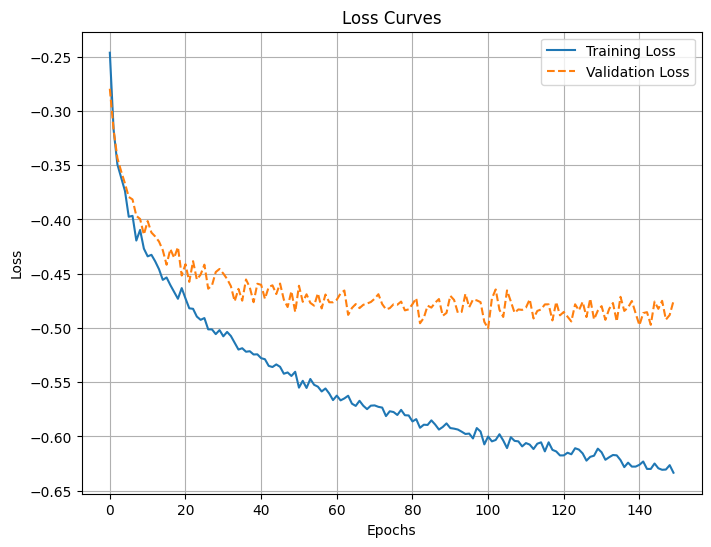

In [38]:
# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
def compute_ncc(image1, image2):
    # Flatten the images to 1D arrays
    image1 = image1.flatten()
    image2 = image2.flatten()
    
    # Compute means
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)
    
    # Compute numerator and denominators
    numerator = np.sum((image1 - mean1) * (image2 - mean2))
    denominator = np.sqrt(np.sum((image1 - mean1)**2) * np.sum((image2 - mean2)**2))
    
    # Return NCC
    return numerator / denominator if denominator != 0 else 0


1/1 [==============================] - 0s 343ms/step
Mean NCC: 0.8770


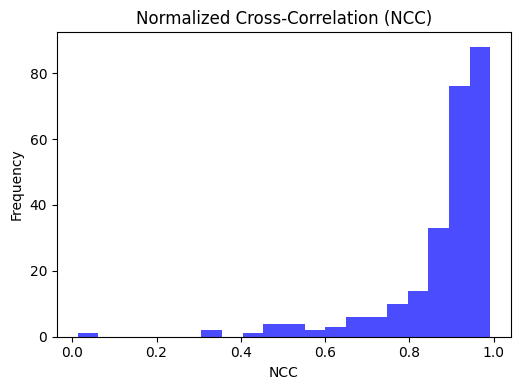

In [42]:
# Compute NCC and DSC for the validation set
ncc_values = []

for i in range(len(val_fixed)):
    fixed_image = val_fixed[i][np.newaxis, ..., np.newaxis]
    moving_image = val_moving[i][np.newaxis, ..., np.newaxis]
    
    # Predict the warped image and deformation field
    predicted_warp, _ = loaded_model.predict([moving_image, fixed_image])
    
    # Compute NCC
    ncc = compute_ncc(val_fixed[i], predicted_warp[0, ..., 0])
    ncc_values.append(ncc)
 

# Compute the mean NCC and DSC
mean_ncc = np.mean(ncc_values)

print(f"Mean NCC: {mean_ncc:.4f}")

# Visualize the NCC and DSC values
plt.figure(figsize=(10, 4))

# Plot NCC values
plt.subplot(1, 2, 1)
plt.hist(ncc_values, bins=20, color='blue', alpha=0.7)
plt.title('Normalized Cross-Correlation (NCC)')
plt.xlabel('NCC')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [43]:
print("Frequency of NCC values:")
print(np.histogram(ncc_values, bins=20)[0])


Frequency of NCC values:
[ 1  0  0  0  0  0  2  0  1  4  4  2  3  6  6 10 14 33 76 88]
